In [1]:
from autoplier.model import set_seed_
import autoplier.model as ap
import csv
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from onto_lib import general_ontology_tools as got
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import time
import warnings

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\envs\autopliernotebook\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
pathway_genes = []
pathway_names = []

with open('c2.cp.v7.4.symbols.gmt', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        pathway_names += [row[0]]
        pathway_genes += [row[2:]]

In [3]:
mlb = MultiLabelBinarizer()
pathways = pd.DataFrame(mlb.fit_transform(pathway_genes), index = pathway_names, columns = mlb.classes_)

In [4]:
rnaseq = pd.read_csv("mat4.csv",index_col = 0).T

In [5]:
# train test split
with open('validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open('pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [6]:
X_train = rnaseq[rnaseq.index.isin(train_egs)]
X_validate = rnaseq[rnaseq.index.isin(validation_egs)]

In [7]:
with open("bulk_labels.json", 'r') as f:
    labels = json.load(f)

In [8]:
sample2types_full = {
        sample: list(map(got.get_term_name, types_ids))
        for sample, types_ids in labels.items()
    }

In [9]:
mlb_full = MultiLabelBinarizer()

types_per_samples = rnaseq.index.map(sample2types_full).values
samples_dummies = pd.DataFrame(mlb_full.fit_transform(types_per_samples), columns=mlb_full.classes_,
                                      index=rnaseq.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}

In [10]:
# fscore metric used to evaluate classifiers
def fscore(p, r):
    denom = p + r or 1

    return 2*(p * r) / denom

In [11]:
types_sizes = samples_dummies.sum()
types_with_data = types_sizes.index.values
all_types = samples_dummies.columns

In [12]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=100, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

In [13]:
ap.set_seed_(100)
mod = ap.autoPLIER(100, regval = 1.0E-6, learning_rate= 0.000156)
mod.fit(X_train, pathways, verbose=0, batch_size = None)

In [14]:
Z = mod.transform(rnaseq, pathways)

In [15]:
import umap

In [32]:
reducer = umap.UMAP(n_neighbors=200)

In [33]:
embedding = reducer.fit_transform(Z)
embedding.shape

(4293, 2)

In [18]:
import seaborn as sns

In [19]:
colors = samples_dummies["dendritic cell"].values

In [20]:
 sample2types_specific = {
        sample: list(map(got.get_term_name, list(got.most_specific_terms(types_ids))))
        for sample, types_ids in labels.items()
    }

In [21]:
mlb_spec = MultiLabelBinarizer()

types_per_sample_spec = rnaseq.index.map(sample2types_specific).values
samples_dummies_spec = pd.DataFrame(mlb_spec.fit_transform(types_per_sample_spec), columns=mlb_spec.classes_,
                                      index=rnaseq.index)

celltypes_spec = samples_dummies_spec.columns.tolist()

In [22]:
celltypes_list = []
for sample in samples_dummies_spec.T:
    s = samples_dummies_spec.T[sample][samples_dummies_spec.T[sample] ==1].index[0]
    celltypes_list+=[s]

In [23]:
types_looking = ['CD4-positive, alpha-beta memory T cell',
 'granulocyte',
 'enteroendocrine cell',
 'sperm',
 'B cell',
 'CD4-positive, alpha-beta T cell',
 'respiratory epithelial cell',
 'CD14-positive monocyte',
 'platelet',
 'blood cell', "other"]
lookupdict = {types_looking[i]: i for i in range(0,len(types_looking))}
lookupdict1 = {i: types_looking[i] for i in range(0,len(types_looking))}

In [24]:

seen_types = []
encoded = []
encoded_list = []

for sample in celltypes_list:
    if(sample not in types_looking):
        encoded += [10]
    else:
        encoded += [lookupdict[sample]]
    

In [34]:
reducer = umap.UMAP(n_neighbors=200)
embedding1 = reducer.fit_transform(rnaseq)
embedding1.shape

(4293, 2)

In [28]:
from sklearn.decomposition import PCA
pca = PCA()
Z_PCA = pca.fit_transform(rnaseq)
Z_PCA.shape

(4293, 4293)

In [35]:
reducer = umap.UMAP(n_neighbors=200)
embedding2 = reducer.fit_transform(Z_PCA[:,:100])
embedding2.shape

(4293, 2)

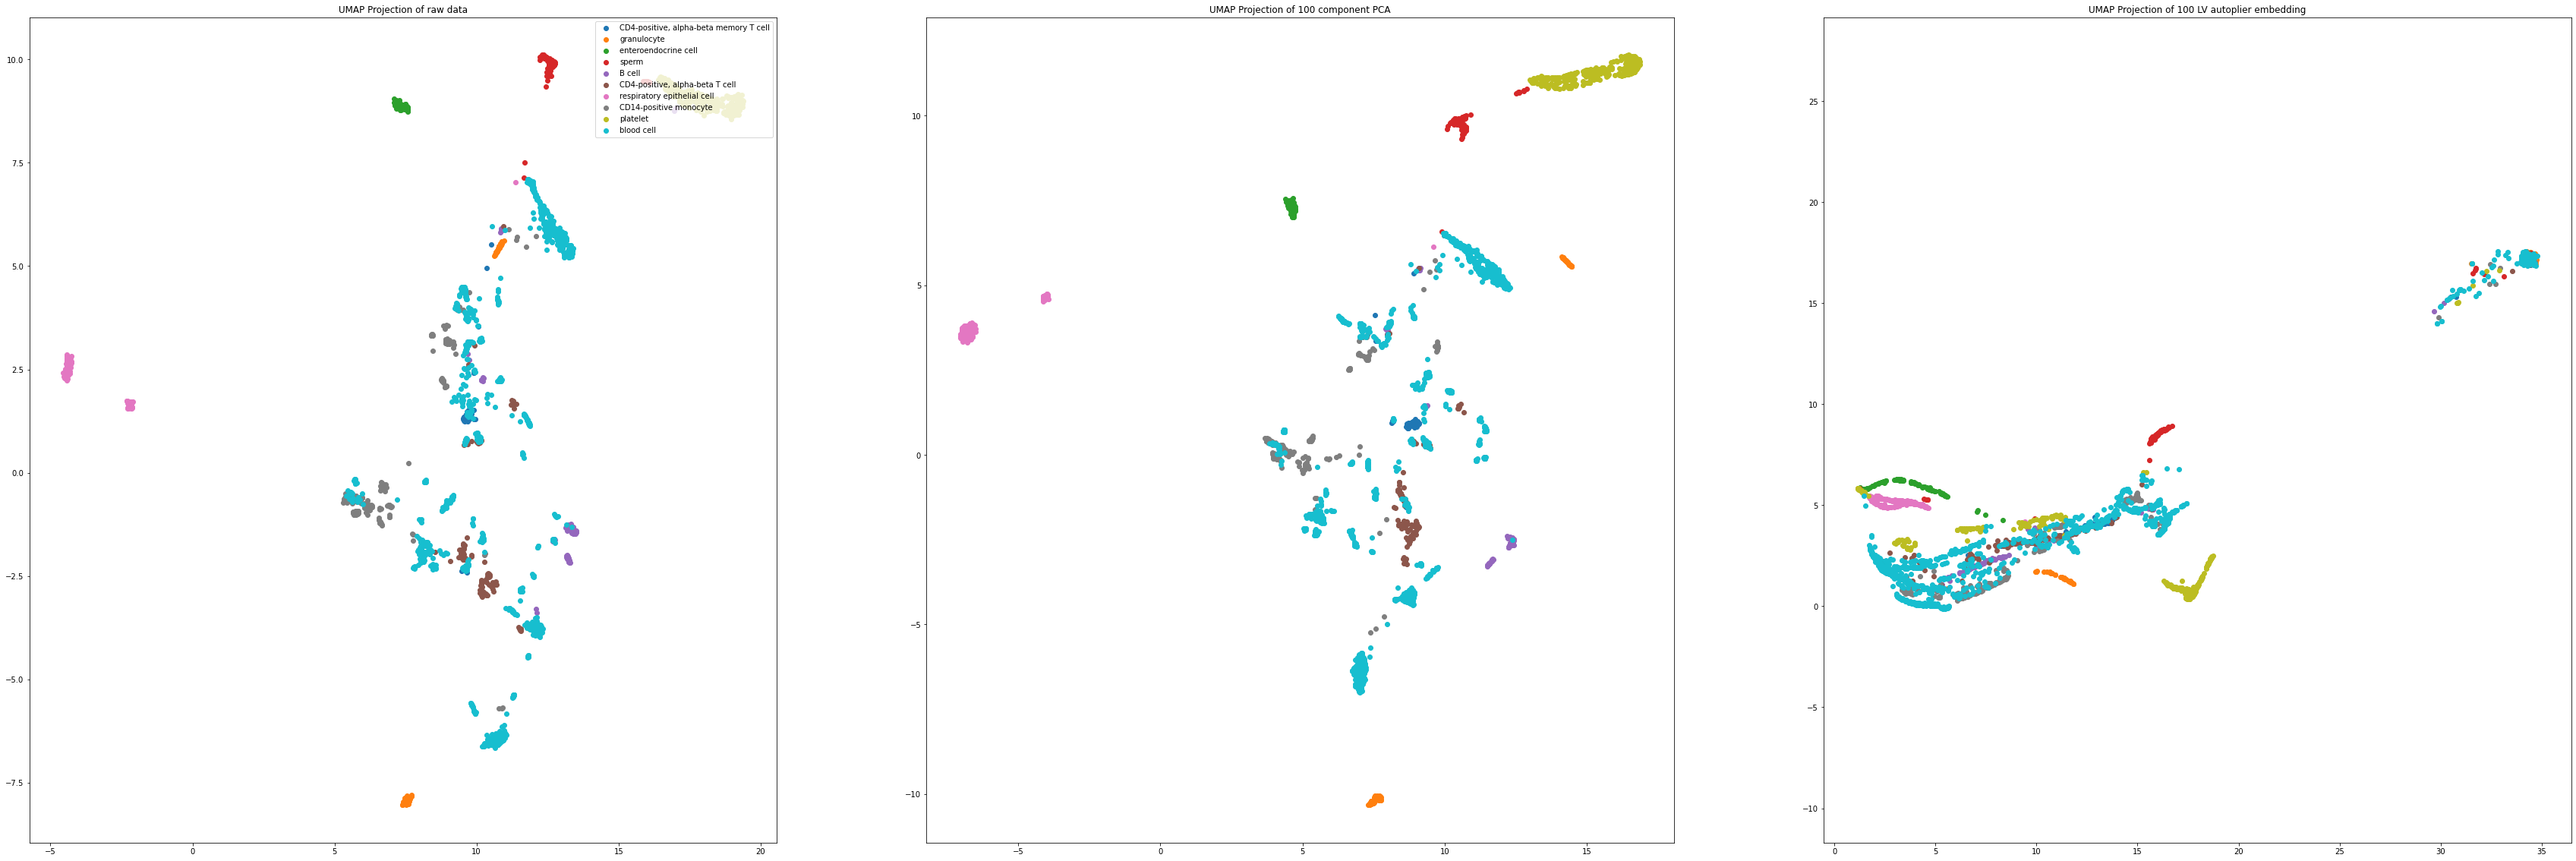

In [36]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(60, 20))
fig.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')
for g in np.unique(encoded):
    ix = np.where(encoded == g)
    if(g < 10):
        ax1.scatter(embedding1[ix,0], embedding1[ix,1], label = lookupdict1[g])
        ax2.scatter(embedding2[ix,0], embedding2[ix,1], label = lookupdict1[g])
        ax3.scatter(embedding[ix,0], embedding[ix,1], label = lookupdict1[g])
    else:
        pass
        #ax1.scatter(embedding[ix,0], embedding[ix,1], c = "lightpink",label = lookupdict1[g])
        #ax2.scatter(embedding1[ix,0], embedding[ix,1], c = "lightpink",label = lookupdict1[g])
plt.gca().set_aspect('equal', 'datalim')
ax1.legend(loc = 1)
ax3.set_title("UMAP Projection of 100 LV autoplier embedding")
ax1.set_title("UMAP Projection of raw data")
ax2.set_title("UMAP Projection of 100 component PCA")
plt.show()